In [215]:
import math
import os
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch
from torch.utils.data import DataLoader, TensorDataset
import lightning as L
import torch.nn.functional as F
import optuna
import tensorboard
from lightning.pytorch.loggers import TensorBoardLogger

import warnings
warnings.filterwarnings("ignore")
from importlib import reload

import torchclustermetrics 
reload(torchclustermetrics)
from torchclustermetrics import silhouette

# this ensures that I can update the class without losing my variables in my notebook
import xenium_cluster
reload(xenium_cluster)
from xenium_cluster import XeniumCluster
from utils.metrics import *

from sklearn.decomposition import PCA

In [216]:
# Path to your .gz file
file_path = 'data/hBreast/transcripts.csv.gz'

# Read the gzipped CSV file into a DataFrame
df_transcripts = pd.read_csv(file_path, compression='gzip')
df_transcripts["error_prob"] = 10 ** (-df_transcripts["qv"]/10)
df_transcripts.head(), df_transcripts.shape

(     transcript_id  cell_id  overlaps_nucleus feature_name  x_location  \
 0  281474976710657   191815                 1          LUM   4797.2383   
 1  281474976710663   214084                 1       SEC11C   4801.7330   
 2  281474976710672   191342                 0         TCIM   4804.4920   
 3  281474976710673   191574                 0         STC1   4805.0483   
 4  281474976710674   192193                 0         STC1   4805.7170   
 
    y_location  z_location         qv  error_prob  
 0   550.61346   15.421524  18.445875    0.014303  
 1   905.11600   14.925031  31.019386    0.000791  
 2   596.05396   14.681485  22.270780    0.005928  
 3   414.38370   19.306356  16.183300    0.024081  
 4   273.81440   16.112896  26.251837    0.002370  ,
 (43775350, 9))

In [ ]:
# drop cells without ids
df_transcripts = df_transcripts[df_transcripts["cell_id"] != -1]

In [217]:
cells = df_transcripts.groupby(['cell_id', 'feature_name']).size().reset_index(name='count')
cells_pivot = cells.pivot_table(index='cell_id', 
                                columns='feature_name', 
                                values='count', 
                                fill_value=0)
cells_pivot.shape

(356743, 541)

In [218]:
location_means = df_transcripts.groupby('cell_id').agg({
    'x_location': 'mean',
    'y_location': 'mean',
    'z_location': 'mean'
}).reset_index()

cells_pivot = location_means.join(cells_pivot, on='cell_id')

In [219]:
# log normalization
cells_pivot.iloc[:, 4:] = np.log1p(cells_pivot.iloc[:, 4:])

In [220]:
pca = PCA(n_components=5)
pca_data = pca.fit_transform(cells_pivot.iloc[:, 4:])

In [271]:
NUM_CLUSTERS = 6
BATCH_SIZE = 512

# Clear the param store in case we're in a REPL
pyro.clear_param_store()

In [272]:
# Load the data (5 PCs for each spot)
data = torch.tensor(pca_data).float()

In [273]:
def spatial_loss(model, guide, data, original_positions, batch_size=256, weight=100.0, sigma=1.0, *args, **kwargs):

    elbo_loss_fn = Trace_ELBO(num_particles=10).differentiable_loss
    elbo_loss = elbo_loss_fn(model, guide, data, *args, **kwargs)
    
    def smoothness_loss(cluster_probs, original_positions, sigma):
        pairwise_distances = torch.cdist(original_positions, original_positions, p=2)
        adjacency_matrix = torch.exp(-pairwise_distances**2 / (2 * sigma**2))
        # cluster_probs = F.softmax(cluster_probs, dim=1)
        cluster_probs = F.gumbel_softmax(cluster_probs, tau=0.25, dim=1)
        diffs = cluster_probs.unsqueeze(1) - cluster_probs.unsqueeze(0)
        smoothness_loss_value = torch.sum(adjacency_matrix * torch.sum(diffs**2, dim=-1))
        return smoothness_loss_value
    
    with pyro.plate("data", len(original_positions), subsample_size=batch_size) as ind:
        cluster_probs = (pyro.param("cluster_concentration_params_q")[ind])
        positions = original_positions[ind]
    
    spatial_loss_value = smoothness_loss(cluster_probs, positions, sigma)
    
    total_loss = elbo_loss + weight * spatial_loss_value
    
    # print(f"ELBO: {elbo_loss.item()}, SPATIAL: {weight * spatial_loss_value.item()}, CUSTOM: {total_loss.item()}")

    return total_loss

In [274]:
def model(data):
    # Define priors for the cluster assignment probabilities and Gaussian parameters
    with pyro.plate("data", len(data), subsample_size=BATCH_SIZE) as ind:
        batch_data = data[ind]
        cluster_probs = pyro.sample("cluster_probs", dist.Dirichlet(torch.ones(BATCH_SIZE, NUM_CLUSTERS)))
        
        # Define the means and variances of the Gaussian components
        cluster_means = pyro.sample("cluster_means", dist.Normal(0., 1.).expand([NUM_CLUSTERS, batch_data.size(1)]).to_event(2))
        cluster_scales = pyro.sample("cluster_scales", dist.LogNormal(0., 1.).expand([NUM_CLUSTERS, batch_data.size(1)]).to_event(2))
        
        # Likelihood of data given cluster assignments
        pyro.sample("obs", dist.MixtureOfDiagNormals(cluster_means, cluster_scales, cluster_probs).to_event(1), obs=batch_data)

def guide(data):
    # Initialize cluster assignment probabilities for the entire dataset
    MIN_CONCENTRATION = 0.1
    cluster_concentration_params_q = pyro.param("cluster_concentration_params_q", torch.ones(data.size(0), NUM_CLUSTERS), constraint=dist.constraints.positive) + MIN_CONCENTRATION
    # Global variational parameters for means and scales
    cluster_means_q_mean = pyro.param("cluster_means_q", torch.randn(NUM_CLUSTERS, data.size(1)))
    cluster_scales_q_mean = pyro.param("cluster_scales_q", torch.ones(NUM_CLUSTERS, data.size(1)), constraint=dist.constraints.positive)
    
    with pyro.plate("data", len(data), subsample_size=BATCH_SIZE) as ind:

        batch_cluster_concentration_params_q = cluster_concentration_params_q[ind]

        # pyro.sample("cluster_assignments", dist.Categorical(batch_cluster_probs_q))
        pyro.sample("cluster_probs", dist.Dirichlet(batch_cluster_concentration_params_q))
        pyro.sample("cluster_means", dist.Normal(cluster_means_q_mean, 0.1).to_event(2))
        pyro.sample("cluster_scales", dist.LogNormal(cluster_scales_q_mean, 0.1).to_event(2))


In [275]:
from pyro.optim import PyroOptim, PyroLRScheduler
from torch.optim import Adam, lr_scheduler

starting_lr = 0.01
ending_lr = 0.00001
N_STEPS = 100000

# Setup the optimizer
adam_params = {"lr": 0.01, "betas": (0.90, 0.999)}
optimizer = PyroOptim(Adam, adam_params)
scheduler = PyroLRScheduler(lr_scheduler.StepLR, {'optimizer': Adam, 'optim_args': {'lr': starting_lr}, 'step_size': 1, 'gamma': (ending_lr / starting_lr) ** (1 / N_STEPS)})

In [276]:
original_positions = torch.tensor(cells_pivot[["x_location", "y_location"]].to_numpy())
original_positions = (original_positions - original_positions.mean(dim=0)) / original_positions.std(dim=0)
# Setup the inference algorithm
svi = SVI(model, guide, scheduler, loss=lambda model, guide, data, original_positions: spatial_loss(model, guide, data, original_positions))

# Setup the inference algorithm
# svi = SVI(model, guide, scheduler, loss=Trace_ELBO(num_particles=10))

In [277]:
# Do gradient steps
for step in range(N_STEPS):
    loss = svi.step(data, original_positions)
    # loss = svi.step(data)
    svi.optim.step()
    if step % 100 == 0:
        print(f"Step {step} : loss = {round(loss/1e6, 4)}")

Step 0 : loss = 2013.6753
Step 100 : loss = 1685.0917
Step 200 : loss = 1576.9843
Step 300 : loss = 1526.9747
Step 400 : loss = 1501.5248
Step 500 : loss = 1484.8531
Step 600 : loss = 1481.8797
Step 700 : loss = 1461.0664
Step 800 : loss = 1448.7946
Step 900 : loss = 1447.727
Step 1000 : loss = 1434.9243
Step 1100 : loss = 1439.5432
Step 1200 : loss = 1433.537
Step 1300 : loss = 1423.6083
Step 1400 : loss = 1417.1491
Step 1500 : loss = 1409.1203
Step 1600 : loss = 1411.7633
Step 1700 : loss = 1400.4669
Step 1800 : loss = 1397.9184
Step 1900 : loss = 1401.894
Step 2000 : loss = 1392.3074
Step 2100 : loss = 1400.0288
Step 2200 : loss = 1400.5552
Step 2300 : loss = 1392.5467
Step 2400 : loss = 1398.7779
Step 2500 : loss = 1395.6426
Step 2600 : loss = 1392.1899
Step 2700 : loss = 1392.2585
Step 2800 : loss = 1392.3971
Step 2900 : loss = 1383.8664
Step 3000 : loss = 1381.7296
Step 3100 : loss = 1383.1619
Step 3200 : loss = 1389.9613
Step 3300 : loss = 1385.5422
Step 3400 : loss = 1381.0374


KeyboardInterrupt: 

In [278]:
# Grab the learned variational parameters
cluster_concentration_params_q = pyro.param("cluster_concentration_params_q")
cluster_probs_q = pyro.sample("cluster_probs", dist.Dirichlet(cluster_concentration_params_q))
cluster_concentration_params_q = cluster_concentration_params_q.detach().numpy()

cluster_assignments_q = cluster_probs_q.argmax(dim=1)
cluster_means_q_mean = pyro.param("cluster_means_q").detach().numpy()
cluster_scales_q_mean = pyro.param("cluster_scales_q").detach().numpy()

# Output the learned cluster probabilities for each data point
print(cluster_assignments_q, cluster_probs_q)

tensor([3, 3, 3,  ..., 4, 5, 4]) tensor([[2.0568e-05, 1.2039e-06, 4.1548e-02, 9.5458e-01, 3.8519e-03, 5.2658e-07],
        [6.1454e-10, 5.7690e-03, 3.1831e-09, 9.7755e-01, 1.2638e-04, 1.6550e-02],
        [1.6736e-03, 6.5701e-05, 1.2120e-02, 9.8481e-01, 9.5891e-04, 3.6902e-04],
        ...,
        [4.1013e-09, 1.2407e-02, 2.9665e-04, 1.8133e-04, 9.8711e-01, 3.1409e-06],
        [3.3723e-08, 1.6002e-03, 8.7630e-03, 4.1509e-03, 8.6680e-03, 9.7682e-01],
        [2.0545e-03, 2.7329e-04, 2.3061e-08, 1.5439e-13, 9.9741e-01, 2.6083e-04]],
       grad_fn=<_DirichletBackward>)


(array([49664.,     0., 63248.,     0., 64676.,     0., 43688.,     0.,
        76815., 58652.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

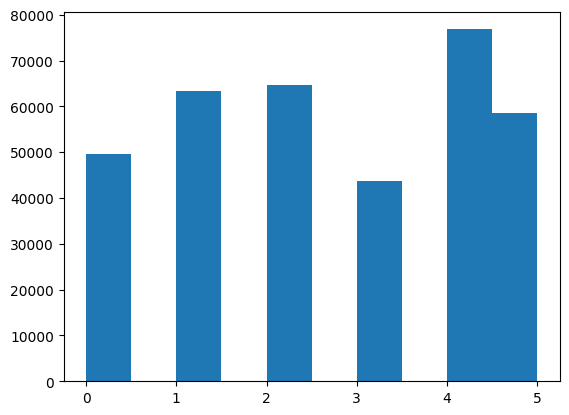

In [279]:
plt.hist(cluster_assignments_q)

In [280]:
np.set_printoptions(suppress=True) 
np.round(cluster_means_q_mean, 4), np.round(cluster_scales_q_mean, 4)

(array([[-4.0771, -0.6747,  0.2822, -0.1124,  0.0033],
        [ 3.8481,  0.5981,  0.1146,  0.0685,  0.1152],
        [ 0.4886, -0.6009, -0.1244, -0.0925, -0.1337],
        [-3.0776,  2.478 ,  0.0717,  0.3067,  0.2251],
        [ 1.9947, -0.1661, -0.0568, -0.0265,  0.0086],
        [-1.3823, -1.1138, -0.193 , -0.1199, -0.1401]], dtype=float32),
 array([[0.0017, 0.0289, 0.1931, 0.0043, 0.0032],
        [0.0443, 0.0027, 0.0015, 0.0005, 0.0733],
        [0.0005, 0.0023, 0.002 , 0.0021, 0.0064],
        [0.7277, 0.5895, 0.7559, 0.8288, 0.0042],
        [0.0004, 0.0026, 0.0023, 0.0022, 0.0149],
        [0.0013, 0.0026, 0.0029, 0.0025, 0.0044]], dtype=float32))

In [281]:
cells_pivot.head()

,cell_id,x_location,y_location,z_location,ABCC11,ACTA2,ACTG2,ADAM9,ADGRE5,ADH1B,...,TUBA4A,TUBB2B,UCP1,USP53,VOPP1,VWF,WARS,ZEB1,ZEB2,ZNF562
0,-1,3891.438437,3353.932461,18.408364,5.361292,8.715716,7.280008,7.457609,5.978886,9.069698,...,6.714171,5.347108,3.433987,7.768956,7.106606,7.209340,6.652863,7.809135,8.440960,6.621406
1,1,1587.163466,1683.353685,15.503466,0.000000,1.098612,0.000000,0.693147,0.000000,2.302585,...,0.000000,0.693147,0.000000,1.791759,0.000000,0.000000,0.000000,0.693147,1.098612,0.000000
2,2,1650.412715,1514.380829,14.616766,0.000000,0.000000,0.000000,0.693147,1.098612,0.693147,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147,2.197225,0.693147
3,3,1645.398455,1703.216616,16.257603,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.098612,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,1664.134134,1506.358351,14.915675,0.000000,1.386294,0.693147,0.000000,0.000000,1.386294,...,1.609438,0.000000,0.000000,1.609438,0.693147,2.302585,1.609438,0.000000,1.609438,0.693147


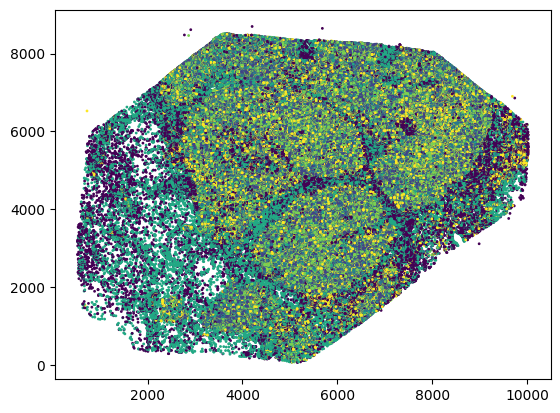

In [283]:
_ = plt.scatter(cells_pivot["x_location"], cells_pivot["y_location"], s=1, c=cluster_assignments_q)